In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline


In [2]:
from file_cache import *
os.environ["CUDA_VISIBLE_DEVICES"] = "1"


2020-07-19 11:22:27,323 util_log.py[153] INFO Start the program at:amax7, 127.0.1.1, with:Load module


File_cache: Adjust notebook work fold to:/share/felix/pj/thyroid_seg/


In [3]:
df = pd.read_csv('/home/felix/pj/thyroid_seg/input/TNSCUI2020_train/train.csv')
print(df.shape)
df.head()

(3644, 2)


,ID,CATE
0,5189.PNG,0
1,2090.PNG,1
2,5156.PNG,0
3,8303.PNG,1
4,9650.PNG,1


In [4]:
df.CATE.value_counts()

1    2003
0    1641
Name: CATE, dtype: int64

In [5]:
from fastai.vision import *
from fastai.callbacks.hooks import *

In [6]:

from file_cache import *

img_file_list = glob('/home/felix/pj/thyroid_seg/input/TNSCUI2020_train/image/*.PNG', recursive=True)

df = pd.DataFrame({'img_file':img_file_list})

df['label_path'] = df.img_file.apply(lambda val: val.replace('image', 'mask'))
df['sn'] = df.img_file.apply(lambda val: os.path.basename(val).split('.')[0]  ).astype(int)
df = df.sort_values('sn')

df['valid'] = df.sn%5 >=4
df.head()

df['size1'] = df.label_path.apply(lambda val: cv2.imread(val).shape[0])
df['size2'] = df.label_path.apply(lambda val: cv2.imread(val).shape[1])
df.sort_values('size1')

codes = list(range(2))
print('codes', list(codes) )


src = (SegmentationItemList.from_df(df, path='/', cols='img_file' )
       .split_from_df(col='valid')
       .label_from_df(cols='label_path', classes=codes)
      )

2020-07-19 11:22:28,643 utils.py[129] INFO Note: NumExpr detected 48 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
2020-07-19 11:22:28,645 utils.py[141] INFO NumExpr defaulting to 8 threads.


codes [0, 1]


In [7]:
np.unique(cv2.imread(df.iloc[0,1]), return_counts=True)

(array([0, 1], dtype=uint8), array([866472,   6438]))

In [8]:
# for file in df.label_path:
#     #print(file)
#     img = cv2.imread(file, cv2.IMREAD_GRAYSCALE)
#     #print(img.shape)
#     cv2.imwrite(file, img/max(1, img.max()) )

## Datasets

In [9]:
size =224
bs = 4
print('size, bs', size, bs)

size, bs 224 4


In [10]:
 
    
print(len(src.train), len(src.valid), codes)

#get_transforms()
data = (src.transform(None, size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

2942 702 [0, 1]


In [11]:
# tmp = df.groupby(['p_id', 'valid'], as_index=False).label_path.count()
# tmp.pivot_table(index='p_id', columns='valid', values='label_path').sort_values(0)

In [12]:
for a, b in data.dl(DatasetType.Train):
    break
    
a.shape

torch.Size([4, 3, 224, 224])

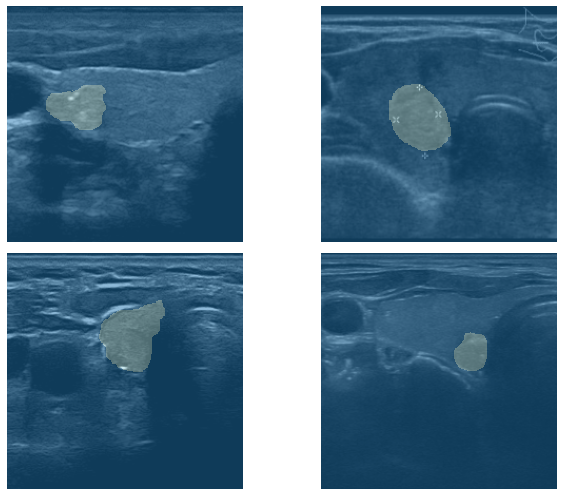

In [13]:
data.show_batch(8, figsize=(10, 7))

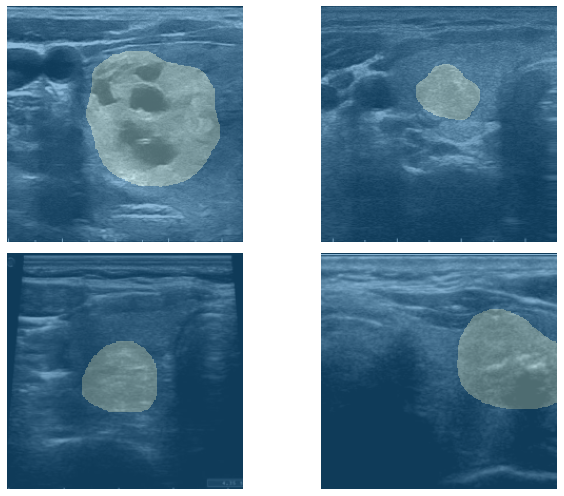

In [14]:
data.show_batch(4, figsize=(10,7), ds_type=DatasetType.Valid)

## Model

In [15]:
name2id = {v:k for k,v in enumerate(codes)}
#void_code = name2id['Void']

# def acc_camvid(input, target):
#     target = target.squeeze(1)
#     mask = target != void_code
#     return (input.argmax(dim=1)[mask]==target[mask]).float().mean()

In [16]:
wd = 1e-2


In [17]:
print('abc', data.c)

abc 2


In [18]:
#多类别的Dice Metrics

from brain.metrics import * 

from functools import partial
def dice_fn(cls_id):
    fn = partial(dice_multiply, cls_id=cls_id) 
    fn.__name__ = f'dice_{cls_id}'
    return fn
 

metrics = [ dice_fn(i) for i in codes ] #, accuracy,
print('len=', len(metrics))
#import ipdb
# ipdb.set_trace()
# learn = unet_learner(data, models.resnet50, metrics=metrics , wd=wd)

# for sn, child in enumerate(learn.model.children()):
#     print(sn, '===', child)

len= 2


In [19]:
# from efficientnet_pytorch import EfficientNet


# # def eff(*args, **kwargs):
# #     class EfficientNet_(EfficientNet):
# #         def __init__(self, *args, **kwargs):
# #             super().__init__(*args, **kwargs)
            
# #         def forward(self, inputs):
# #             bs = inputs.size(0)
# #             x = self.extract_features(inputs)
# #             return x
# #     name='0'
# #     return EfficientNet_.from_pretrained(f'efficientnet-b{name}', in_channels=3)

# import os
# # os.environ["CUDA_VISIBLE_DEVICES"]="0"
# from file_cache import *
# from fastai.vision import *
# from fastai.callbacks.hooks import *
# from fvcore.common.registry import Registry
# from torchvision import models
# from enum import Enum
# from fastai.vision.models.unet import UnetBlock


# def dummy_eval(m: nn.Module, size: tuple = (64, 64)):
#     "Pass a `dummy_batch` in evaluation mode in `m` with `size`."
#     dummy = torch.rand((1, 3, *size)).requires_grad_(False)
#     return m.eval()(dummy)


# def in_channels(m: nn.Module) -> List[int]:
#     "Return the shape of the first weight layer in `m`."
#     for l in m.modules():
#         if hasattr(l, 'weight'): return l.weight.shape[1]
#     raise Exception(f'No weight layer:{type(m)}')


# def flatten_moduleList(module: nn.Module) -> List[nn.Module]:
#     "If the ModuleList can be found in children, flatten it. Since ModuleList can not support hook "
#     res_list = []
#     for item in module.children():
#         if isinstance(item, nn.ModuleList):
#             res_list.extend(flatten_moduleList(item))
#         else:
#             res_list.append(item)
#     return res_list

# def get_unet_config(model, img_size=(512, 512)):
#     "Cut the network to several blocks, the width and high of the image are reduced by half. And the image W and H >= 7"
#     x = torch.rand(1, in_channels(model), *img_size)
#     hooks = []
#     count = 0
#     layer_meta = []
#     layers = []


#     def hook(module, input, output):
#         "To get the meta of the layer infomation"
#         nonlocal count
#         if len(output.shape) == 4:
#             b, c, w, h = output.shape
#             layer_meta.append((count, type(module).__name__, c, w, h, output.shape))
#         layers.append(module)
#         count += 1

#     for module in flatten_moduleList(model):
#         hooks.append(module.register_forward_hook(hook))

#     # make a forward pass to trigger the hooks
#     model(x)
#     for h in hooks:
#         h.remove()

#     layer_meta = pd.DataFrame(layer_meta, columns=['sn', 'layer', 'c', 'w', 'h', 'size'])
#     img_size = [x.shape[-1] // (2 ** i) for i in range(8)]
#     print('img_size1', img_size)
#     img_size = [size for size in img_size if size >= 7]
#     print('img_size2', img_size)
#     print(layer_meta)
#     layer_meta:pd.DataFrame = layer_meta.loc[(layer_meta.h.isin(img_size))].drop_duplicates(['h'], keep='last')
#     print(layer_meta)
#     layer_meta = layer_meta.head(5)
#     print(layer_meta)
#     #assert len(layer_meta) == 5, f'Only cut {len(layer_meta)} layers from the pretrained model '

#     layer_size = list(layer_meta['size'])
#     layers = [layers[i] for i in layer_meta.sn]
#     return layer_size, layers


# class DynamicUnet(SequentialEx):
#     "Create a U-Net from a given architecture."

#     def __init__(self, encoder: nn.Module, n_classes: int, img_size: Tuple[int, int] = (256, 256),
#                  blur: bool = False,
#                  blur_final=True, self_attention: bool = False,
#                  y_range: Optional[Tuple[float, float]] = None,
#                  last_cross: bool = True, bottle: bool = False, **kwargs):


#         imsize = tuple(img_size)
#         sfs_szs, select_layer = get_unet_config(encoder, img_size)
#         ni = sfs_szs[-1][1]
#         sfs_szs = list(reversed(sfs_szs[:-1]))
#         select_layer = list(reversed(select_layer[:-1]))
#         self.sfs = hook_outputs(select_layer, detach=False)
#         x = dummy_eval(encoder, imsize).detach()

#         middle_conv = nn.Sequential(conv_layer(ni, ni * 2, **kwargs),
#                                     conv_layer(ni * 2, ni, **kwargs)).eval()
#         x = middle_conv(x)
#         layers = [encoder, batchnorm_2d(ni), nn.ReLU(), middle_conv]

#         for i, x_size in enumerate(sfs_szs):
#             not_final = i != len(sfs_szs) - 1
#             up_in_c, x_in_c = int(x.shape[1]), int(x_size[1])
#             do_blur = blur and (not_final or blur_final)
#             sa = self_attention and (i == len(sfs_szs) - 3)
#             unet_block = UnetBlock(up_in_c, x_in_c, self.sfs[i], final_div=not_final, blur=do_blur, self_attention=sa,
#                                    **kwargs).eval()
#             layers.append(unet_block)
#             x = unet_block(x)

#         ni = x.shape[1]
#         if imsize != sfs_szs[0][-2:]: layers.append(PixelShuffle_ICNR(ni, **kwargs))
#         x = PixelShuffle_ICNR(ni)(x)
#         if imsize != x.shape[-2:]: layers.append(Lambda(lambda x: F.interpolate(x, imsize, mode='nearest')))
#         if last_cross:
#             layers.append(MergeLayer(dense=True))
#             ni += in_channels(encoder)
#             layers.append(res_block(ni, bottle=bottle, **kwargs))
#         layers += [conv_layer(ni, n_classes, ks=1, use_activ=False, **kwargs)]
#         if y_range is not None: layers.append(SigmoidRange(*y_range))
#         super().__init__(*layers)


# def efficient_unet(name='5'):
#     from efficientnet_pytorch import EfficientNet
#     class EfficientNet_(EfficientNet):
#         def __init__(self, *args, **kwargs):
#             super().__init__(*args, **kwargs)

#         def forward(self, inputs):
#             x = self.extract_features(inputs)
#             return x
#     return EfficientNet_.from_pretrained(f'efficientnet-b{name}', in_channels=3)


# def unet_learner(data:DataBunch, arch:Callable, pretrained:bool=True, blur_final:bool=True,
#                  norm_type:Optional[NormType]=None, split_on:Optional[SplitFuncOrIdxList]=None, blur:bool=False,
#                  self_attention:bool=False, y_range:Optional[Tuple[float,float]]=None, last_cross:bool=True,
#                  bottle:bool=False, cut:Union[int,Callable]=None, **learn_kwargs:Any)->Learner:
    
#     encoder = nn.Sequential(*list(models.resnet50(pretrained=True).children())[:-3])

#     unet = DynamicUnet(encoder, n_classes=2, img_size=(224, 224), blur=False, blur_final=False,
#                         self_attention=False, y_range=None, norm_type=NormType,
#                         last_cross=True,
#                         bottle=False)
 
#     learn = Learner(data, unet, **learn_kwargs)
#     return learn

# metrics = [ dice_fn(i) for i in codes ]
# learn = unet_learner(data, models.resnet50, metrics=metrics, wd=wd)

In [20]:
from dynamic_unet.base import *
def unet_learner(data:DataBunch, arch:Callable, pretrained:bool=True, blur_final:bool=True,
                 norm_type:Optional[NormType]=None, split_on:Optional[SplitFuncOrIdxList]=None, blur:bool=False,
                 self_attention:bool=False, y_range:Optional[Tuple[float,float]]=None, last_cross:bool=True,
                 bottle:bool=False, cut:Union[int,Callable]=None, **learn_kwargs:Any)->Learner:
    
    encoder = nn.Sequential(*list(models.resnet50(pretrained=True).children())[:-3])

    unet = DynamicUnet(encoder, n_classes=2, img_size=(224, 224), blur=False, blur_final=False,
                        self_attention=False, y_range=None, norm_type=NormType,
                        last_cross=True,
                        bottle=False)
 
    learn = Learner(data, unet, **learn_kwargs)
    return learn

metrics = [ dice_fn(i) for i in codes ]
learn = unet_learner(data, models.resnet50, metrics=metrics, wd=wd)

   sn       layer     c    w    h               size
2   2        ReLU    64  112  112  (1, 64, 112, 112)
4   4  Sequential   256   56   56   (1, 256, 56, 56)
5   5  Sequential   512   28   28   (1, 512, 28, 28)
6   6  Sequential  1024   14   14  (1, 1024, 14, 14)


In [21]:
os.path.abspath('./output/model')

'/share/felix/pj/thyroid_seg/output/model'

In [22]:
! pip show fastai

Name: fastai
Version: 1.0.62.dev0
Summary: fastai makes deep learning with PyTorch faster, more accurate, and easier
Home-page: https://github.com/fastai/fastai
Author: Jeremy Howard
Author-email: info@fast.ai
License: Apache Software License 2.0
Location: /share/felix/pj/fastai
Requires: bottleneck, fastprogress, beautifulsoup4, matplotlib, numexpr, numpy, nvidia-ml-py3, pandas, packaging, Pillow, pyyaml, requests, scipy, torch, torchvision, spacy
Required-by: 


In [23]:

learn.model_dir=os.path.abspath('./output/model')
os.makedirs(learn.model_dir, exist_ok=True)
learn.lr_find()

epoch,train_loss,valid_loss,dice_0,dice_1,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


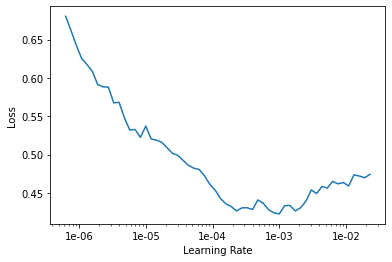

In [24]:
learn.recorder.plot()

In [25]:
lr = 1e-4
learn.fit_one_cycle(5, slice(lr), pct_start=0.9)

epoch,train_loss,valid_loss,dice_0,dice_1,time
0,0.137305,0.156159,0.962977,0.402468,03:16
1,0.135546,0.112260,0.972202,0.566998,03:20
2,0.087639,0.104744,0.974464,0.743288,03:17
3,0.102950,0.106291,0.976899,0.789456,03:16
4,0.047499,0.073816,0.980736,0.825276,03:16


In [26]:
lr = 1e-4
learn.fit_one_cycle(5, slice(lr), pct_start=0.9)

epoch,train_loss,valid_loss,dice_0,dice_1,time
0,0.038493,0.082529,0.981740,0.811746,03:15
1,0.035220,0.080499,0.981871,0.822120,03:15
2,0.046736,0.109064,0.976629,0.799748,03:16
3,0.040833,0.092130,0.980873,0.828578,03:16
4,0.036669,0.080227,0.981864,0.840452,03:16


In [27]:
lr = 1e-4
learn.fit_one_cycle(10, slice(lr), pct_start=0.9)

epoch,train_loss,valid_loss,dice_0,dice_1,time
0,0.024862,0.080655,0.982515,0.844302,03:15
1,0.021810,0.091073,0.982825,0.845020,03:15
2,0.023067,0.097572,0.982462,0.837937,03:15
3,0.019889,0.098645,0.982301,0.835438,03:16
4,0.024874,0.096174,0.981946,0.826934,03:16
5,0.023816,0.101292,0.981356,0.830399,03:16
6,0.026955,0.156433,0.977727,0.741492,03:16
7,0.026139,0.120327,0.977623,0.778502,03:16
8,0.032004,0.099519,0.978994,0.815742,03:16
9,0.016431,0.100293,0.981926,0.841778,03:15


In [28]:
lr = 1e-4
learn.fit_one_cycle(10, slice(lr), pct_start=0.9)

epoch,train_loss,valid_loss,dice_0,dice_1,time
0,0.012642,0.116656,0.981952,0.839791,03:16
1,0.012060,0.124775,0.982059,0.841072,03:16
2,0.012648,0.118456,0.981903,0.842730,03:16
3,0.012952,0.112705,0.981600,0.834557,03:16
4,0.011298,0.208540,0.981038,0.831861,03:15
5,0.012177,0.196076,0.980337,0.812293,03:16
6,0.021079,0.100164,0.980356,0.827897,03:16
7,0.018369,0.129243,0.979837,0.826216,03:16
8,0.021224,0.109838,0.980113,0.824025,03:16
9,0.011734,0.118012,0.981495,0.833228,03:15


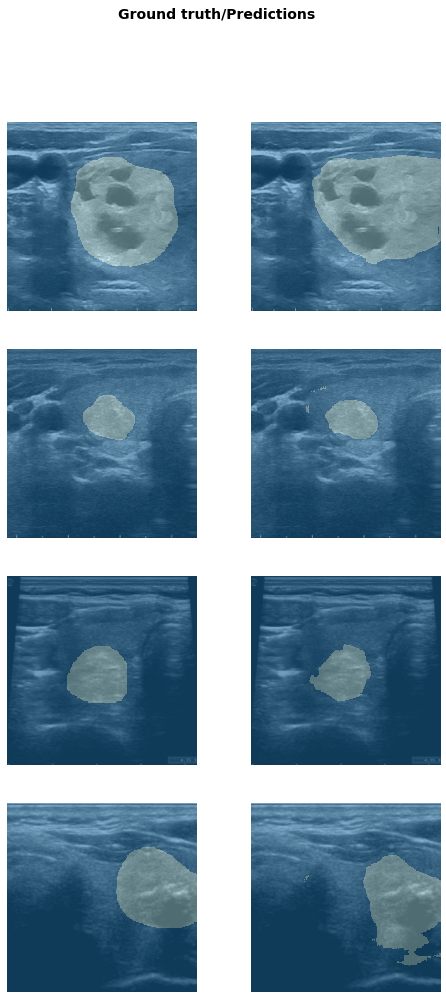

In [29]:
learn.show_results(DatasetType.Valid, rows=40)
